## Only using tensorflow to import a dataset

In [91]:
import numpy as np
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

<ipython-input-92-de66bb0fd666>:2: DeprecationWarning: This function is deprecated. Please call randint(0, 60000 + 1) instead
  start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]


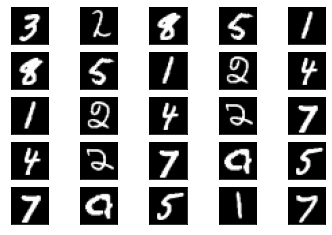

In [92]:
side = 5
start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]
fig, ax = plt.subplots(side, side)
for a in range(side):
    for b in range(side):
        ax[a, b].axes.xaxis.set_visible(False)
        ax[a, b].axes.yaxis.set_visible(False)
        ax[a, b].imshow(x_train[2 * a + b + start, :, :], cmap='gray')
plt.show()

## Code

## Import

In [93]:
import numpy as np

## flatten and reshape

In [94]:
print("x_train:", x_train.shape)
x_train = x_train.reshape(x_train.shape[0], -1).T # flatten
print("x_train flatten:", x_train.shape)

print("x_test:", x_test.shape)
x_test = x_test.reshape(x_test.shape[0], -1).T # flatten
print("x_test flatten:", x_test.shape)

print("y_train:", y_train.shape)
y_train = y_train.reshape(y_train.shape[0],1).T # reshape
print("y_train:", y_train.shape)

print("y_test:", y_test.shape)
y_test = y_test.reshape(y_test.shape[0],1).T # reshape
print("y_test:", y_test.shape)

x_train: (60000, 28, 28)
x_train flatten: (784, 60000)
x_test: (10000, 28, 28)
x_test flatten: (784, 10000)
y_train: (60000,)
y_train: (1, 60000)
y_test: (10000,)
y_test: (1, 10000)


## One Hot

In [95]:
def one_hot_encoder(y):
    y_onehot = np.zeros((len(np.unique(y)), y.shape[1]))
    
    for i in range(y_onehot.shape[1]):
        y_onehot[y[0][i]][i] = 1
        
    return y_onehot

In [96]:
y_train_onehot = one_hot_encoder(y_train)
y_test_onehot = one_hot_encoder(y_test)

print(y_train_onehot)
print(y_test_onehot)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Normalization

In [97]:
x_train = x_train/255
x_test = x_test/255

## initialize_parameters

In [98]:
def initialize_parameters(layers_dims):
    parameters = {}
    L = len(layers_dims) - 1
        
    for l in range(1, L+1):
        parameters['W'+str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2./layers_dims[l-1])
        parameters['b'+str(l)] = np.ones((layers_dims[l], 1), dtype=np.float32)
    
    return parameters

## activation_funtion

In [99]:
def activation_funtion(Z, activation):
    if activation == "relu":
        return np.maximum(np.zeros(1), Z)
        
    if activation == "sigmoid":
        return 1 / (1 + np.exp(-Z))
    
    return Z

## forward_propagation

In [100]:
def forward_propagation(X, parameters, activation):
    cache = {}
    L = len(parameters) // 2
    cache['A0'] = X
    l = 0
    
    for l in range(1,L):
        cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
        cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])

    l += 1
    
    cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
    cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])
    
    return cache

## compute_cost

In [101]:
def compute_cost(AL,Y, loss = "cross_entropy"):
    m = Y.shape[1]
    
    AL = AL.T
    if loss == "cross_entropy":
        epsilon = 1e-7
        cost = -(1/m) * np.sum(np.multiply(np.log(AL + epsilon), Y) + np.multiply(np.log(1-AL + epsilon), 1-Y))
        return np.squeeze(cost)


In [102]:
def activation_derivative(Z, activation):
    if activation == "relu":
        dZ = np.ones(Z.shape)
        return (dZ >= 0).astype(int)
        
    if activation == "sigmoid":
        return np.multiply(activation_funtion(Z, "sigmoid"), (1- activation_funtion(Z, "sigmoid")))
    
    return Z

## back_propagation

In [103]:
def back_propagation(X, Y, parameters, cache, activation):
    grads = {}
    L = len(parameters) // 2
    m = Y.shape[1]
    
    grads["dZ" + str(L)] = cache['A' + str(L)] - Y
    grads["dW" + str(L)] = (1/m) * np.dot(grads["dZ" + str(L)], cache['A' + str(L-1)].T)
    grads["db" + str(L)] = (1/m) * np.sum(grads["dZ" + str(L)], axis= 1, keepdims= True)
    
    for l in range(L-1,0,-1):
        grads["dZ" + str(l)] = np.multiply(np.dot(parameters["W" + str(l+1)].T, grads["dZ" + str(l+1)]), activation_derivative(cache["Z" + str(l)],activation[l-1]))        
        grads["dW" + str(l)] = (1/m) * np.dot(grads["dZ" + str(l)], cache['A' + str(l-1)].T)
        grads["db" + str(l)] = (1/m) * np.sum(grads["dZ" + str(l)], axis= 1, keepdims= True)
    
    return grads

## update_parameters

In [104]:
def update_parameters(grads, parameters, lr=0.01):
    L = len(parameters) // 2
    
    for l in range(1, L+1):
        parameters['W'+str(l)] = parameters['W'+str(l)] - np.multiply(grads['dW'+str(l)], lr)
        parameters['b'+str(l)] = parameters['b'+str(l)] - np.multiply(grads['db'+str(l)], lr)
    
    return parameters

## prediction

In [105]:
def prediction(X, Y, parameters, activation):
    cache = forward_propagation(X, parameters, activation)
    
    cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, Y)
    
    pred = cache['A' + str(len(parameters) // 2)] - Y
    
    print(pred)
    
    return "train cost: " + str(cost)

In [109]:
def run(X_train,Y_train, layers_dims, activation,print_cost= True,lr= 0.001, iter= 100, X_test=[], Y_test=[]):
    parameters = initialize_parameters(layers_dims)
    
    for i in range(iter):
        cache = forward_propagation(X_train, parameters, activation)
    
        if i % 100 == 0 and print_cost:
            cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, Y_train)
            print("cost train: " + str(cost), end= " ")
            
            if len(X_test) != 0 and len(Y_test) != 0:
                cache_test = forward_propagation(X_test, parameters, activation)
                cost = compute_cost(cache_test['A' + str(len(parameters) // 2)].T, Y_test)
                print("cost test: " + str(cost), end= "")
            print()
            
        grads = back_propagation(X_train, Y_train, parameters, cache, activation)

        parameters = update_parameters(grads, parameters, lr)
    
    return parameters

In [110]:
layers_dims1 = [x_train.shape[0],128,64,32,16,10]
activation1 = ["relu","relu","relu","relu","sigmoid"]
# loss_funtion = "cross_entropy"

print(x_train.shape)
print(y_train.shape)

parameters = run(x_train, y_train_onehot, layers_dims1, activation1, iter=500,X_test= x_test,Y_test= y_test_onehot)

(784, 60000)
(1, 60000)
cost train: 22.994702612495868 cost test: 22.997819881542597
cost train: 3.6284007724393774 cost test: 3.640109953969575
cost train: 3.1397418478327945 cost test: 3.1207091288827584
cost train: 2.9494513092422756 cost test: 2.9355293405281575
cost train: 2.8868513097768282 cost test: 2.8701648132413626


In [ ]:
layers_dims2 = [2,3,1] # 2NN
activation2 = ["relu","relu"] # 2 Activation to 2NN

X = np.array([[3, 5, 4, 7, 10], [4, 6, 8, 7, 10]])
Y = np.array([[7, 11, 8, 14, 20]])

print(X.shape)
print(Y.shape)

for i in range(3):
    parameters2 = run(X, Y, layers_dims2, activation2,print_cost = False, iter=50000)

    cache = forward_propagation([[1],[3]], parameters2, activation2)
    print(cache['A2'])

(2, 5)
(1, 5)
[[3.17037554]]
[[3.17038486]]
[[3.25289455]]


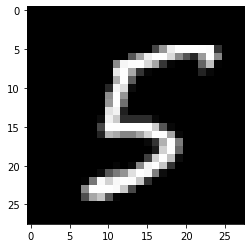

(784, 1)
(28, 28)


IndexError: list index out of range

In [ ]:
for i in [23, 45, 150, 1234]:
    plt.imshow(x_test[i], cmap='gray')
    plt.show()

    x_test_test = x_test[i].flatten() # flatten
    x_test_test = x_test_test.reshape(x_test_test.shape[0], 1)
    print(x_test_test.shape)
    print(x_test[i].shape)
    cache = forward_propagation(x_test_test, parameters, activation1)
    
    print(cache['A2'].argmax())